**TM10007 Machine Learning**

## Import dependencies and data

In [195]:
import os
import zipfile
import pandas as pd
import numpy as np
import shutil
import subprocess
import shutil
import os
import stat
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from os import path
from sklearn import model_selection
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.utils import resample
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay

## if data.csv is not present download it from github
if not os.path.isfile("ecg_data.csv"):
    ## clone repo from githun
    if not os.path.isdir("tm10007_ml"):
        !git clone https://github.com/jveenland/tm10007_ml.git
    ## extract zip file
    if not os.path.isfile("tm10007_ml/ecg/ecg_data.csv"):
        with zipfile.ZipFile('tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
            zip_ref.extractall('tm10007_ml/ecg')
    ## move data file to root folder
    shutil.move('tm10007_ml/ecg/ecg_data.csv', 'ecg_data.csv')

    ## Delete cloned repo
    for root, dirs, files in os.walk("./tm10007_ml"):  
        for dir in dirs:
            os.chmod(path.join(root, dir), stat.S_IRWXU)
        for file in files:
            os.chmod(path.join(root, file), stat.S_IRWXU)
    shutil.rmtree('./tm10007_ml')

data = pd.read_csv('ecg_data.csv', index_col=0)

## Inspect imported data and clean missing data

### Plot number of missing data per features and per patient

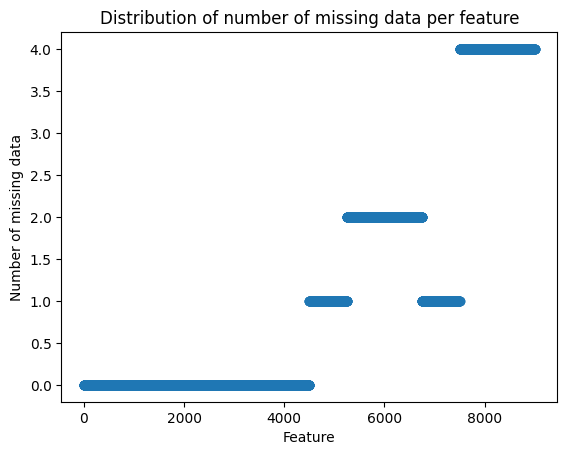

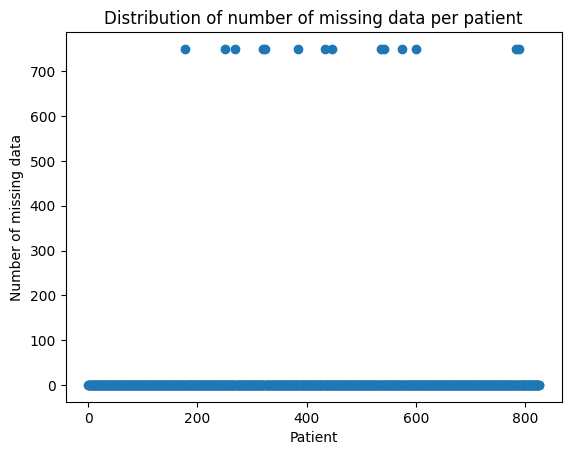

In [136]:
# exclude label column
values_features = data.drop(['label'], axis=1)

# plot the distribution of missing data per feature
num_zeros_features = (values_features == 0).sum(axis=0)
plt.scatter(range(len(num_zeros_features)),num_zeros_features)
plt.title("Distribution of number of missing data per feature")
plt.ylabel('Number of missing data')
plt.xlabel('Feature')
plt.show()

# plot the distribution of missing data per patient
num_zeros_patients=(values_features == 0).sum(axis=1)
plt.scatter(range(len(num_zeros_patients)),num_zeros_patients)
plt.title("Distribution of number of missing data per patient")
plt.ylabel('Number of missing data')
plt.xlabel('Patient')
plt.show()

### Delete rows with missing data

In [137]:
values_data = data.drop(['label'], axis=1)
mask = (values_data != 0).all(axis=1)
clean_data=data[mask]
dirty_data=data[~mask]

### Plot number of missing data per features and per patient after data cleanup

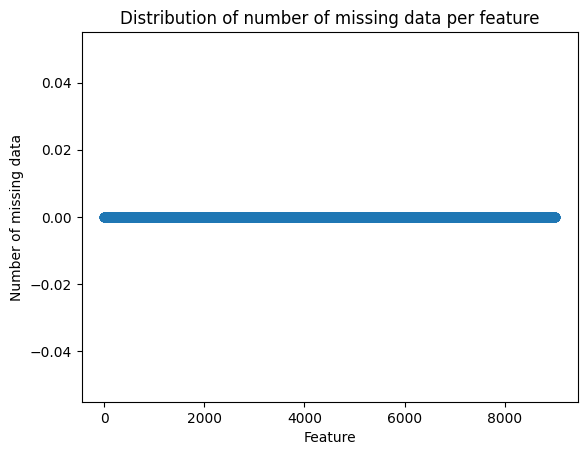

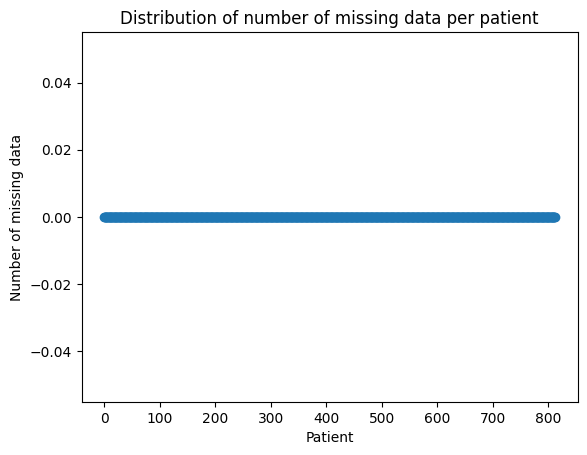

In [138]:
# exclude label column
values_clean_data = clean_data.drop(['label'], axis=1)
# plot the distribution of missing data per feature
num_zeros_features = (values_clean_data == 0).sum(axis=0)
plt.scatter(range(len(num_zeros_features)),num_zeros_features)
plt.title("Distribution of number of missing data per feature")
plt.ylabel('Number of missing data')
plt.xlabel('Feature')
plt.show()

# plot the distribution of missing data per patient
num_zeros_patients=(values_clean_data == 0).sum(axis=1)
plt.scatter(range(len(num_zeros_patients)),num_zeros_patients)
plt.title("Distribution of number of missing data per patient")
plt.ylabel('Number of missing data')
plt.xlabel('Patient')
plt.show()

## Split data into test and train data

In [139]:
def clean_outlier(dataframe):
  new_dfs = []
  for i in range(9001):
        data=dataframe[dataframe.columns[i]]
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQD = Q3 - Q1
        Upper_outlier_boundary = Q3 + (1.5 * IQD)
        Lower_outlier_boundary = Q1 - (1.5 * IQD)
        clipped_col = pd.DataFrame({dataframe.columns[i]: dataframe[dataframe.columns[i]].clip(Lower_outlier_boundary, Upper_outlier_boundary)})
        new_dfs.append(clipped_col)
  clean_outlier_data = pd.concat(new_dfs, axis=1)
  return clean_outlier_data


In [140]:
ECG_ABNORMAL = clean_data[clean_data['label'] == 1]
ECG_NORMAL = clean_data[clean_data['label'] == 0]

x_train_abnormal, x_test_abnormal = model_selection.train_test_split(ECG_ABNORMAL, test_size=0.2, random_state=30)
x_train_normal, x_test_normal = model_selection.train_test_split(ECG_NORMAL,test_size = 0.2,random_state=30)

train_set = pd.concat([x_train_normal,x_train_abnormal])
test_set_new = pd.concat([x_test_normal,x_test_abnormal])

ECG_TRAIN_ABNORMAL = train_set[train_set['label'] == 1]
ECG_TRAIN_NORMAL = train_set[train_set['label'] == 0]

ECG_TRAIN_DOWNSAMPLED = resample(ECG_TRAIN_NORMAL,
                                      replace=False,
                                      n_samples=len(ECG_TRAIN_ABNORMAL),
                                      random_state=30)

# Concat normal and abnormal
train_set_downsampled = pd.concat([ECG_TRAIN_ABNORMAL, ECG_TRAIN_DOWNSAMPLED])

# Shuffle
train_set_shuffled = train_set_downsampled.sample(frac=1, random_state=30)

# clean outliers from datasets
train_set = clean_outlier(train_set_shuffled)
test_set = clean_outlier(test_set_new)


Scale features of train and test set

In [141]:
# scaling the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
# fit the scaler on the train set
scaler.fit(train_set)

# transform both train and test data set with the scaler
train_set_scaled = pd.DataFrame(scaler.transform(train_set))
train_set_scaled.columns=data.columns.values
test_set_scaled = pd.DataFrame(scaler.transform(test_set))
test_set_scaled.columns=data.columns.values

PCA

Number of components to reach 80% variance: 85


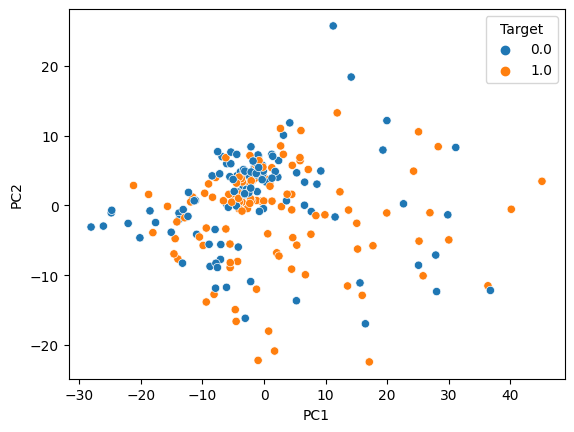

In [142]:
x = train_set_scaled.iloc[:, :-1].values
y = train_set_scaled.iloc[:, -1].values

pca = PCA()
X_pca = pca.fit_transform(x)

# initialize variables
cumulative_variance = 0
num_components = 0

# loop over each principal component and add its explained variance to the cumulative variance
while cumulative_variance < 0.8:
    cumulative_variance += pca.explained_variance_ratio_[num_components]
    num_components += 1

# print the number of components required to reach 80% variance
print("Number of components to reach 80% variance:", num_components)

pca = PCA(num_components)
X_pca = pca.fit_transform(x)

# Twee componenten plotten
pca_2components = PCA(n_components=2)
X_pca_2components = pca_2components.fit_transform(x)
df_pca = pd.DataFrame(data=X_pca_2components, columns=['PC1', 'PC2'])
df_pca['Target'] = y
sns.scatterplot(x='PC1', y='PC2', hue='Target', data=df_pca)
plt.show()

In [143]:
# Colorplot
def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)
            
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    elif hasattr(clf, "predict_proba"):
        Z = clf.predict_proba(features)
    else:
        Z = clf.predict(features)
        
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

KNN

In [177]:
# KNN classifier
knn = KNeighborsClassifier(n_neighbors = 5, weights='uniform')
knn.fit(X_pca,y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

# Compute the accuracy of the classifier
binary_accuracy = make_scorer(accuracy_score)
accuracy_scores = cross_val_score(knn, X_pca, y, cv=cv, scoring=binary_accuracy)
mean_accuracy_score = accuracy_scores.mean()
print("The mean accuracy score of the classifier is: {:.2f}".format(mean_accuracy_score))

# Compute the precision of the classifier
binary_precision = make_scorer(precision_score, average='binary')
precision_scores = cross_val_score(knn, X_pca, y, cv=cv, scoring=binary_precision)
mean_precision_score = precision_scores.mean()
print("The mean precision score of the classifier is: {:.2f}".format(mean_precision_score))

# Compute the recall of the classifier
binary_recall = make_scorer(recall_score, average='binary')
recall_scores = cross_val_score(knn, X_pca, y, cv=cv, scoring=binary_recall)
mean_recall_score = recall_scores.mean()
print("The mean recall score of the classifier is: {:.2f}".format(mean_recall_score))

# Compute the F1 score of the classifier
binary_f1 = make_scorer(f1_score, average='binary')
f1_scores = cross_val_score(knn, X_pca, y, cv=cv, scoring=binary_f1)
mean_f1_score = f1_scores.mean()
print("The mean F1 score of the classifier is: {:.2f}".format(mean_f1_score))

# Compute the weighted F1 score of the classifier
fbeta_scorer = make_scorer(fbeta_score, beta=1.732, average='binary')
fbeta_scores = cross_val_score(knn, X_pca, y, cv=cv, scoring=fbeta_scorer)
mean_fbeta_score = fbeta_scores.mean()
print("The mean weighted F1 score of the classifier is: {:.2f}".format(mean_fbeta_score))

# ROC curve
RocCurveDisplay.from_estimator(knn, X_pca, y)

# # Finding optimal hyperparameters for weighted fbeta_score
# params = {'n_neighbors': [3, 5, 7, 9],
#           'weights': ['uniform', 'distance']}

# grid_search = GridSearchCV(knn, param_grid=params, cv=5, scoring=fbeta_scorer)
# grid_search.fit(X_pca, y)
# print("Best hyperparameters:", grid_search.best_params_)

The mean accuracy score of the classifier is: 0.60
The mean precision score of the classifier is: 0.65
The mean recall score of the classifier is: 0.41
The mean F1 score of the classifier is: 0.50
The mean weighted F1 score of the classifier is: 0.44
Best hyperparameters: {'n_neighbors': 5, 'weights': 'uniform'}
Best recall score: 0.4901114904308722


SVM RBF

The mean accuracy score of the classifier is: 0.50
The mean precision score of the classifier is: 0.40
The mean recall score of the classifier is: 0.80
The mean F1 score of the classifier is: 0.53
The mean weighted F1 score of the classifier is: 0.64


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


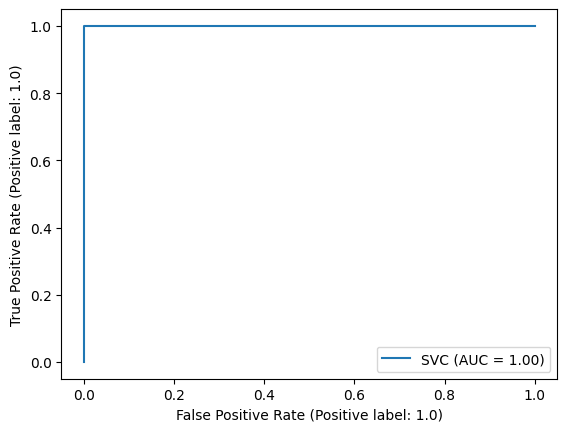

In [196]:
# SVM RBF
svmrbf = SVC(kernel='rbf', gamma=0.1, C=0.1)
svmrbf.fit(X_pca,y)

# Compute the accuracy of the classifier
binary_accuracy = make_scorer(accuracy_score)
accuracy_scores = cross_val_score(svmrbf, X_pca, y, cv=cv, scoring=binary_accuracy)
mean_accuracy_score = accuracy_scores.mean()
print("The mean accuracy score of the classifier is: {:.2f}".format(mean_accuracy_score))

# Compute the precision of the classifier
binary_precision = make_scorer(precision_score, average='binary')
precision_scores = cross_val_score(svmrbf, X_pca, y, cv=cv, scoring=binary_precision)
mean_precision_score = precision_scores.mean()
print("The mean precision score of the classifier is: {:.2f}".format(mean_precision_score))

# Compute the recall of the classifier
binary_recall = make_scorer(recall_score, average='binary')
recall_scores = cross_val_score(svmrbf, X_pca, y, cv=cv, scoring=binary_recall)
mean_recall_score = recall_scores.mean()
print("The mean recall score of the classifier is: {:.2f}".format(mean_recall_score))

# Compute the F1 score of the classifier
binary_f1 = make_scorer(f1_score, average='binary')
f1_scores = cross_val_score(svmrbf, X_pca, y, cv=cv, scoring=binary_f1)
mean_f1_score = f1_scores.mean()
print("The mean F1 score of the classifier is: {:.2f}".format(mean_f1_score))

# Compute the weighted F1 score of the classifier
fbeta_scorer = make_scorer(fbeta_score, beta=1.732, average='binary')
fbeta_scores = cross_val_score(svmrbf, X_pca, y, cv=cv, scoring=fbeta_scorer)
mean_fbeta_score = fbeta_scores.mean()
print("The mean weighted F1 score of the classifier is: {:.2f}".format(mean_fbeta_score))

# ROC curve
RocCurveDisplay.from_estimator(svmrbf, X_pca, y)

# # Optimize hyperparameters for highest weighted fbeta_score
# param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
# grid_search = GridSearchCV(estimator=svmrbf, param_grid=param_grid, cv=cv, scoring=fbeta_scorer)
# grid_search.fit(X_pca, y)
# print("Best parameters: ", grid_search.best_params_)

SVM polynomial

The mean accuracy score of the classifier is: 0.71
The mean precision score of the classifier is: 0.72
The mean recall score of the classifier is: 0.66
The mean F1 score of the classifier is: 0.68
The mean weighted F1 score of the classifier is: 0.67


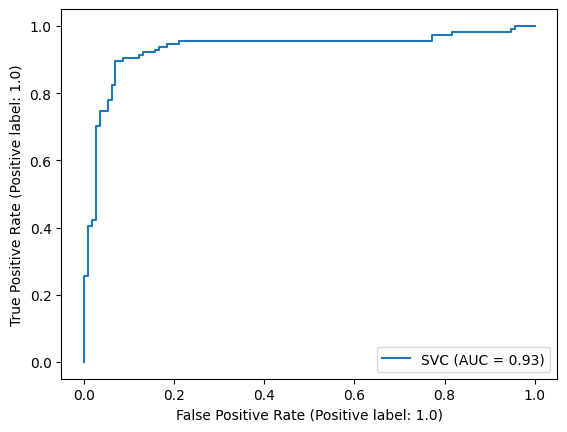

In [198]:
# SVM polynomial
svmpoly = SVC(kernel='poly', degree=1, gamma='scale', C=10)
svmpoly.fit(X_pca,y)

# Compute the accuracy of the classifier
binary_accuracy = make_scorer(accuracy_score)
accuracy_scores = cross_val_score(svmpoly, X_pca, y, cv=cv, scoring=binary_accuracy)
mean_accuracy_score = accuracy_scores.mean()
print("The mean accuracy score of the classifier is: {:.2f}".format(mean_accuracy_score))

# Compute the precision of the classifier
binary_precision = make_scorer(precision_score, average='binary')
precision_scores = cross_val_score(svmpoly, X_pca, y, cv=cv, scoring=binary_precision)
mean_precision_score = precision_scores.mean()
print("The mean precision score of the classifier is: {:.2f}".format(mean_precision_score))

# Compute the recall of the classifier
binary_recall = make_scorer(recall_score, average='binary')
recall_scores = cross_val_score(svmpoly, X_pca, y, cv=cv, scoring=binary_recall)
mean_recall_score = recall_scores.mean()
print("The mean recall score of the classifier is: {:.2f}".format(mean_recall_score))

# Compute the F1 score of the classifier
binary_f1 = make_scorer(f1_score, average='binary')
f1_scores = cross_val_score(svmpoly, X_pca, y, cv=cv, scoring=binary_f1)
mean_f1_score = f1_scores.mean()
print("The mean F1 score of the classifier is: {:.2f}".format(mean_f1_score))

# Compute the weighted F1 score of the classifier
fbeta_scorer = make_scorer(fbeta_score, beta=1.732, average='binary')
fbeta_scores = cross_val_score(svmpoly, X_pca, y, cv=cv, scoring=fbeta_scorer)
mean_fbeta_score = fbeta_scores.mean()
print("The mean weighted F1 score of the classifier is: {:.2f}".format(mean_fbeta_score))

# ROC curve
RocCurveDisplay.from_estimator(svmpoly, X_pca, y)

# Optimize hyperparameters for highest weighted fbeta_score
# param_grid = {'C': [0.1, 1, 10], 'kernel': ['poly'], 'degree': [1, 2, 3, 4], 'gamma': ['scale', 'auto']}
# grid_search = GridSearchCV(svmpoly, param_grid=param_grid, scoring=fbeta_scorer, cv=5)
# grid_search.fit(X_pca, y)
# print("Best hyperparameters:", grid_search.best_params_)

Decision tree

The mean accuracy score of the classifier is: 0.55
The mean precision score of the classifier is: 0.54
The mean recall score of the classifier is: 0.62
The mean F1 score of the classifier is: 0.57
The mean weighted F1 score of the classifier is: 0.59


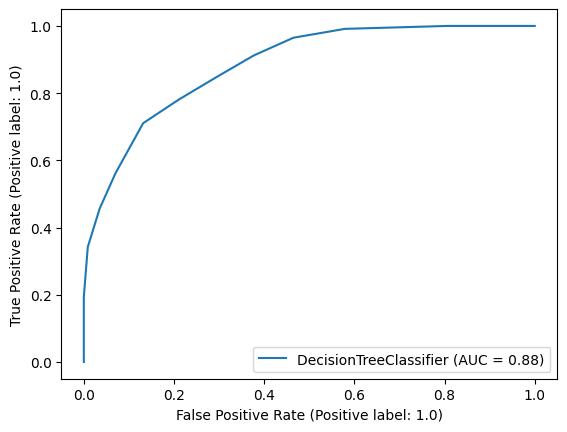

In [199]:
# Decision tree classifier
decision_tree = DecisionTreeClassifier(max_depth= None, min_samples_leaf=16, min_samples_split=2)
decision_tree.fit(X_pca,y)

# Compute the accuracy of the classifier
binary_accuracy = make_scorer(accuracy_score)
accuracy_scores = cross_val_score(decision_tree, X_pca, y, cv=cv, scoring=binary_accuracy)
mean_accuracy_score = accuracy_scores.mean()
print("The mean accuracy score of the classifier is: {:.2f}".format(mean_accuracy_score))

# Compute the precision of the classifier
binary_precision = make_scorer(precision_score, average='binary')
precision_scores = cross_val_score(decision_tree, X_pca, y, cv=cv, scoring=binary_precision)
mean_precision_score = precision_scores.mean()
print("The mean precision score of the classifier is: {:.2f}".format(mean_precision_score))

# Compute the recall of the classifier
binary_recall = make_scorer(recall_score, average='binary')
recall_scores = cross_val_score(decision_tree, X_pca, y, cv=cv, scoring=binary_recall)
mean_recall_score = recall_scores.mean()
print("The mean recall score of the classifier is: {:.2f}".format(mean_recall_score))

# Compute the F1 score of the classifier
binary_f1 = make_scorer(f1_score, average='binary')
f1_scores = cross_val_score(decision_tree, X_pca, y, cv=cv, scoring=binary_f1)
mean_f1_score = f1_scores.mean()
print("The mean F1 score of the classifier is: {:.2f}".format(mean_f1_score))

# Compute the weighted F1 score of the classifier
fbeta_scorer = make_scorer(fbeta_score, beta=1.732, average='binary')
fbeta_scores = cross_val_score(decision_tree, X_pca, y, cv=cv, scoring=fbeta_scorer)
mean_fbeta_score = fbeta_scores.mean()
print("The mean weighted F1 score of the classifier is: {:.2f}".format(mean_fbeta_score))

# ROC curve
RocCurveDisplay.from_estimator(decision_tree, X_pca, y)

# # Optimizing hyperparameters for highest weighted fbeta_scorer
# params = {'max_depth': [None, 5, 10, 15, 20],
#           'min_samples_split': [2, 5, 10, 15],
#           'min_samples_leaf': [1, 2, 4, 8, 16]}

# grid_search = GridSearchCV(decision_tree, param_grid=params, cv=5, scoring=fbeta_scorer)
# grid_search.fit(X_pca, y)
# print("Best hyperparameters:", grid_search.best_params_)

Random Forest

The mean accuracy score of the classifier is: 0.64
The mean precision score of the classifier is: 0.64
The mean recall score of the classifier is: 0.67
The mean F1 score of the classifier is: 0.65
The mean weighted F1 score of the classifier is: 0.68


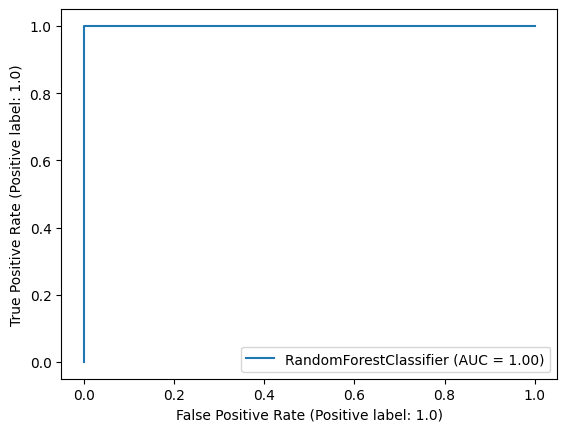

In [200]:
# Random forest classifier
random_forest = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300)
random_forest.fit(X_pca,y)

# Compute the accuracy of the classifier
binary_accuracy = make_scorer(accuracy_score)
accuracy_scores = cross_val_score(random_forest, X_pca, y, cv=cv, scoring=binary_accuracy)
mean_accuracy_score = accuracy_scores.mean()
print("The mean accuracy score of the classifier is: {:.2f}".format(mean_accuracy_score))

# Compute the precision of the classifier
binary_precision = make_scorer(precision_score, average='binary')
precision_scores = cross_val_score(random_forest, X_pca, y, cv=cv, scoring=binary_precision)
mean_precision_score = precision_scores.mean()
print("The mean precision score of the classifier is: {:.2f}".format(mean_precision_score))

# Compute the recall of the classifier
binary_recall = make_scorer(recall_score, average='binary')
recall_scores = cross_val_score(random_forest, X_pca, y, cv=cv, scoring=binary_recall)
mean_recall_score = recall_scores.mean()
print("The mean recall score of the classifier is: {:.2f}".format(mean_recall_score))

# Compute the F1 score of the classifier
binary_f1 = make_scorer(f1_score, average='binary')
f1_scores = cross_val_score(random_forest, X_pca, y, cv=cv, scoring=binary_f1)
mean_f1_score = f1_scores.mean()
print("The mean F1 score of the classifier is: {:.2f}".format(mean_f1_score))

# Compute the weighted F1 score of the classifier
fbeta_scorer = make_scorer(fbeta_score, beta=1.732, average='binary')
fbeta_scores = cross_val_score(random_forest, X_pca, y, cv=cv, scoring=fbeta_scorer)
mean_fbeta_score = fbeta_scores.mean()
print("The mean weighted F1 score of the classifier is: {:.2f}".format(mean_fbeta_score))

# ROC curve
RocCurveDisplay.from_estimator(random_forest, X_pca, y)

# # Finding hyperparameters for highest weighted fbeta_score
# params = {'n_estimators': [100, 200, 300],
#           'max_depth': [None, 5, 10],
#           'min_samples_split': [2, 5, 10],
#           'min_samples_leaf': [1, 2, 4]}

# grid_search = GridSearchCV(random_forest, param_grid=params, cv=5, scoring=fbeta_scorer)
# grid_search.fit(X_pca, y)
# print("Best hyperparameters:", grid_search.best_params_)

Linear

The mean accuracy score of the classifier is: 0.69
The mean precision score of the classifier is: 0.70
The mean recall score of the classifier is: 0.66
The mean F1 score of the classifier is: 0.67
The mean weighted F1 score of the classifier is: 0.66


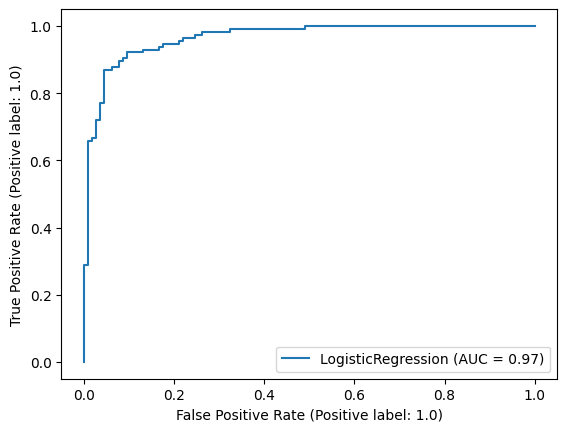

In [201]:
# Linear classifier
linear = LogisticRegression(C=0.1, penalty='l2', max_iter=1000)
linear.fit(X_pca,y)

# Compute the accuracy of the classifier
binary_accuracy = make_scorer(accuracy_score)
accuracy_scores = cross_val_score(linear, X_pca, y, cv=cv, scoring=binary_accuracy)
mean_accuracy_score = accuracy_scores.mean()
print("The mean accuracy score of the classifier is: {:.2f}".format(mean_accuracy_score))

# Compute the precision of the classifier
binary_precision = make_scorer(precision_score, average='binary')
precision_scores = cross_val_score(linear, X_pca, y, cv=cv, scoring=binary_precision)
mean_precision_score = precision_scores.mean()
print("The mean precision score of the classifier is: {:.2f}".format(mean_precision_score))

# Compute the recall of the classifier
binary_recall = make_scorer(recall_score, average='binary')
recall_scores = cross_val_score(linear, X_pca, y, cv=cv, scoring=binary_recall)
mean_recall_score = recall_scores.mean()
print("The mean recall score of the classifier is: {:.2f}".format(mean_recall_score))

# Compute the F1 score of the classifier
binary_f1 = make_scorer(f1_score, average='binary')
f1_scores = cross_val_score(linear, X_pca, y, cv=cv, scoring=binary_f1)
mean_f1_score = f1_scores.mean()
print("The mean F1 score of the classifier is: {:.2f}".format(mean_f1_score))

# Compute the weighted F1 score of the classifier
fbeta_scorer = make_scorer(fbeta_score, beta=1.732, average='binary')
fbeta_scores = cross_val_score(linear, X_pca, y, cv=cv, scoring=fbeta_scorer)
mean_fbeta_score = fbeta_scores.mean()
print("The mean weighted F1 score of the classifier is: {:.2f}".format(mean_fbeta_score))

# ROC curve
RocCurveDisplay.from_estimator(linear, X_pca, y)

# # Optimizing hyperparameters for highest fbeta_scorer
# param_grid = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
# grid_search = GridSearchCV(linear, param_grid, cv=5, scoring=fbeta_scorer)
# grid_search.fit(X_pca, y)
# print("Best hyperparameters: ", grid_search.best_params_)

Combination

In [202]:
# Combining 3 classifiers with highest weighted fbeta
predicted_labels_svmrbf = cross_val_predict(svmrbf, X_pca, y, cv=cv)
predicted_labels_svmpoly = cross_val_predict(svmpoly, X_pca, y, cv=cv)
predicted_labels_linear = cross_val_predict(linear, X_pca, y, cv=cv)
voting_predictions = np.array([predicted_labels_svmrbf, predicted_labels_random_forest, predicted_labels_linear])
final_classification = np.apply_along_axis(lambda x: np.argmax(np.bincount(x.astype(int))), axis=0, arr=voting_predictions)

# final_classification = [max(elem) for elem in zip(predicted_labels_svmrbf, predicted_labels_random_forest, predicted_labels_linear)]

y = train_set_scaled.iloc[:, -1].values
correct_labels = y.tolist()

accuracy = accuracy_score(correct_labels, final_classification)
print(f"The accuracy score is: {accuracy:.2f}")

precision = precision_score(correct_labels,final_classification, average='binary')
print(f"The precision score is: {precision:.2f}")

recall = recall_score(correct_labels, final_classification, average='binary')
print(f"The recall score is: {recall:.2f}")

f1 = f1_score(correct_labels, final_classification, average='binary')
print(f"The f1 score is: {f1:.2f}")

weighted_f1 = fbeta_score(correct_labels, final_classification, beta=1.732, average='binary')
print(f"The weighted f1 score is: {weighted_f1:.2f}")

The accuracy score is: 0.68
The precision score is: 0.66
The recall score is: 0.75
The f1 score is: 0.70
The weighted f1 score is: 0.72
